<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_classification/blob/master/Car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Проект "Классификация автомобилей по изображению"

**Цель:** Классифицировать модель автомобиля по фотографии.

**Задание:** Обучить нейронную сеть определять модель автомомбиля по изображению. Модели автомобилей, представленные в тренировочных данных ('Приора', 'Ford Focus', 'Самара', 'ВАЗ-2110', 'Жигули', 'Нива', 'Калина',   'ВАЗ-2109', 'Volkswagen Passat', 'ВАЗ-21099') 

**Данные:** 
1. train.csv - обучающая выборка
2. train.zip - картинки к обучающей выборке
3. sample-submission.csv - тестовая выборка
4. test.zip - картинки к тестовой выборке




In [ ]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Библиотеки:

In [ ]:
import os #Для работы с файлами
import sys 
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #Для отрисовки изображений
%matplotlib inline
from tqdm.notebook import tqdm # ход выполнения

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [ ]:
# Версии
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.0
Keras        : 2.8.0


## Данные

In [ ]:
# Подключаем Google disk
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Распаковываем архивы
!unzip -q '/content/drive/MyDrive/data/sf-dl-car-classification.zip'  -d '/content/cars'

In [ ]:
!unzip -q "/content/cars/train.zip" -d '/content/cars/img'
!unzip -q "/content/cars/test.zip" -d '/content/cars/img'

In [ ]:
# Загружаем датасеты
train_df = pd.read_csv('/content/cars/train.csv')
test_sub = pd.read_csv('/content/cars/sample-submission.csv')

In [ ]:
train_df.sample(3)

,Id,Category
11069,26605.jpg,6
1009,223519.jpg,0
3541,290672.jpg,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


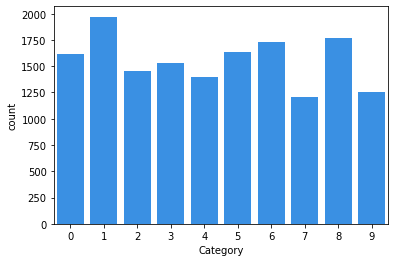

In [ ]:
sns.countplot(x='Category', data=train_df, color='dodgerblue')

В обучающей выборке пропусков нет. Объекты распределены по классам не совсем равномерно, но в каждой категории достаточно объектов. 

In [ ]:
# Список названий моделей - имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

**Посмотрим изображения автомобилей**

In [ ]:
# Пути до изображений
train_img_path = '/content/cars/img/train/'
test_img_path = '/content/cars/img/test_upload/'

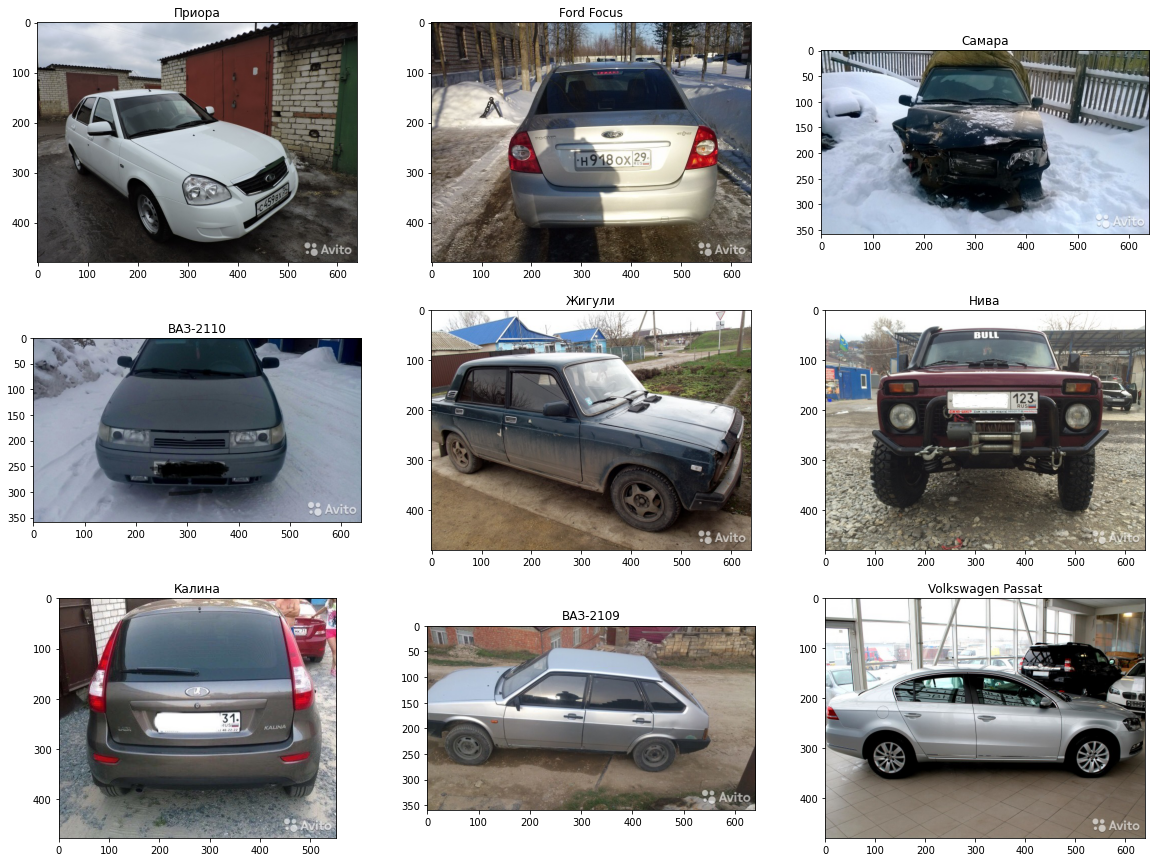

In [ ]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(3, 3, figsize=(20,15))
for i, axi in enumerate(ax.flat):
  car_path = train_img_path + str(i)+'/'
  img_path = car_path + random.choice(os.listdir(car_path))
  img = Image.open(img_path)
  axi.imshow(img)
  axi.set_title(class_names[i])
plt.show()

Фотографии в разном разрешении, в основном размером 640 на 480. Автомобили сняты с разного ракурса.

## Подготовка данных для нейросети

**Основные насройки**

In [ ]:
IMAGE_SIZE = (90, 120)
BATCH_SIZE = 32
RANDOM_SEED = 42
VALIDATION_SPLIT=0.2





**Аугментация данных**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, # Нормализуем яркости от 0 до 1
    rotation_range=10, # Поворачиваем изображения при генерации выборки
    horizontal_flip=True, # Отзеркаливание изображения
    shear_range=0.2, # Задает диапазон сдвига пикселей изображения (угол сдвига в градусах в направлении против часовой стрелки)
    brightness_range=(0.8, 1.2), # Диапазон для выбора значения сдвига яркости.
    validation_split=VALIDATION_SPLIT # Указываем разделение изображений на обучающую и тестовую выборку
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255, # нормализуем яркости от 0 до 1
    validation_split=VALIDATION_SPLIT # Указываем разделение изображений на обучающую и тестовую выборку
)

test_datagen = ImageDataGenerator(
    rescale = 1./255 # нормализуем яркости от 0 до 1
)

**Генерация данных**

In [ ]:
train_generator = train_datagen.flow_from_directory(
   train_img_path,
   target_size=IMAGE_SIZE,
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True,
   seed=RANDOM_SEED,
   subset='training'
    
)

valid_generator = valid_datagen.flow_from_directory(
    train_img_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_sub,
    directory=test_img_path,
    x_col='Id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False

)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим, что получилось:

In [ ]:
def show_first_image(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  """Функция выводит на экран изображения, обработанные генератором"""

  generator = itertools.islice(generator, count) # Создаёт итератор по ограниченному подмножеству элементов переданного объекта.
  fig, ax = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  
  for batch, ax in zip(generator, ax):
    
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0])
    else:
      img_batch = batch
      img = img_batch[0]
    
    if not normalized:
      img = img.astype(np.uint8)
    
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1

    if labels:
      ax.set_title(f'Class: {label}')
  
  plt.show()




Обучающая выборка:


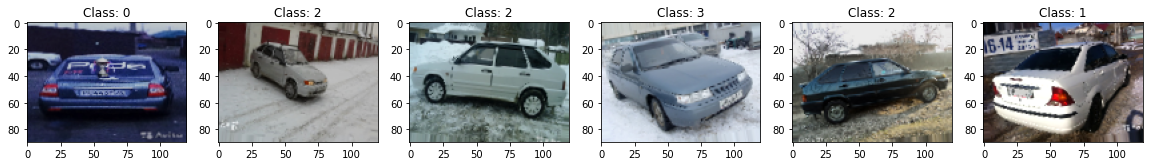

Валидационная выборка:


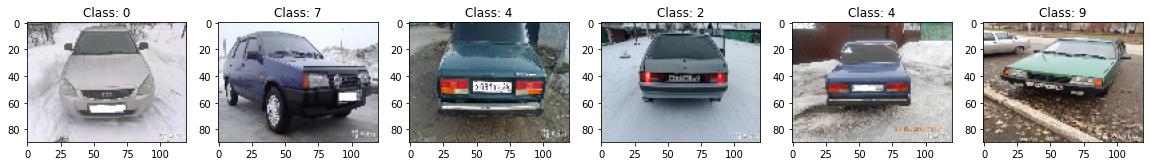

Тестовая выборка:


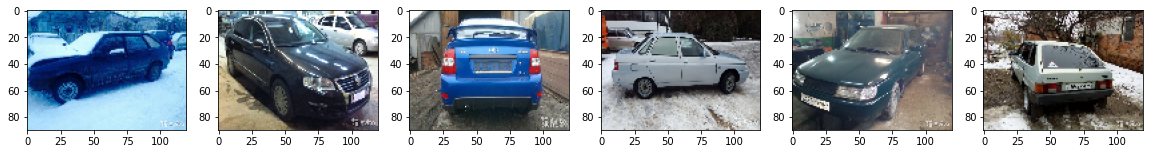

In [ ]:
print('Обучающая выборка:')
show_first_image(train_generator, normalized=True)

print('Валидационная выборка:')
show_first_image(valid_generator, normalized=True)

print('Тестовая выборка:')
show_first_image(test_generator, labels=False, normalized=True)


## Построение модели

In [ ]:
# Загружаем предобученную сеть Xception:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

83697664/83683744 [==============================] - 0s 0us/step
